# **2: Network Testing**

This tutorial demonstrates how to test the double LSTM-based model for the sequence-to-scalar future hysteresis step prediction. The test set seqeunces include data that has the same sampling time steps as the training dataset. However the code is able to decipher the sequence length (provided that it has a sampling frequency), and upsample or downsample as needed to fit the model criteria. If the sequence is longer than the designed memory, then only the most recent time steps (amount to the total training memory time) are taken. If the data length is shorter, then the extra empty memory will take the constant of the most distant memory data point. The test set consists of multiple frequencies (7), temperatures (3), and 5 different combinations of past and future lengths, totaling 105 sequences, each with 1,000 time steps.

# **Step 0: Import Packages**

In this step we import the important packages that are necessary for the testing.

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import json
import h5py
import math
import csv
import time
import matplotlib.pyplot as plt

# **Step 1: Define Network Structure**
The structure of the duel LSTM-based encoder-projector-decoder neural network are defined here. The network structure does not change from the training structure. Refer to the PyTorch document for more details.

In [9]:
# Define model structures and functions

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.lstm_B = nn.LSTM(1, 12, num_layers=1, batch_first=True, bidirectional=False)

        self.lstm_H = nn.LSTM(1, 12, num_layers=1, batch_first=True, bidirectional=False)

        self.projector = nn.Sequential(
            nn.Linear(12 * 2 + 2 , 12 * 2 + 2),
            nn.ReLU(),
            nn.Linear(12 * 2 + 2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )


    def forward(self, seq_B: Tensor, seq_H: Tensor, scal: Tensor, T: Tensor, device) -> Tensor:

        seq_B = seq_B.float()
        seq_H = seq_H.float()
        scal = scal.float()
        T = T.float()

        x_B, _ = self.lstm_B(seq_B)
        x_B = x_B[:, -1, :]
        x_H, _ = self.lstm_H(seq_H)
        x_H = x_H[:, -1, :]

        output = self.projector(torch.cat((scal, T, x_B, x_H), dim=1))
        output = output.to(device)

        return output

# **Step 2: Load the Testing Dataset**

The testing dataset consists of 105 sequences with varying past and future lengths, such as (900,100), (700,300), (500,500), (300,700), and (100,900). This function processes the raw data by interpolating and aligning the input sequences (B, H, T) to match the model's configuration. The model is designed to operate with a sampling rate of 16 MHz and a memory length of 80 time steps. Output H sequence is post processed again to provide autoregressive function. The user must specify the sampling frequency of the test data, which is 16 MHz in this case.

In [10]:
def get_dataset(sample_freq_test, B, H, H_true, T, data_length, path_root):
    """
    Prepares the test dataset by interpolating, aligning, and normalizing the inputs and outputs.

    Args:
        sample_freq_test (float): Sampling frequency of test data in Hz.
        B (np.ndarray): Input B data including past and future sequences.
        H (np.ndarray): Input magnetic field strength data representing the memory (past) sequence.
        H_true (np.ndarray): Ground truth magnetic field strength including past and future values, used for evaluation.
        T (np.ndarray): Temperature information.
        data_length (int): Sequence length expected by the model.

    Returns:
        TensorDataset: Torch dataset containing (in_B, in_H, B_scal, T_scal, out)
        normH (list): Normalization parameters for the output [mean_out, std_out].
    """

    # Load normalization parameters from JSON
    norm_file_name = 'Normalization_Params.json'
    with open(path_root + norm_file_name, 'r') as f:
        Param = json.load(f)

    print("Normalization Initiated")

    # Extract normalization parameters
    mean_B, std_B = np.array(Param['mean_B']), np.array(Param['std_B'])
    mean_H, std_H = np.array(Param['mean_H']), np.array(Param['std_H'])
    mean_out, std_out = np.array(Param['mean_out']), np.array(Param['std_out'])
    mean_Scal, std_Scal = np.array(Param['mean_Scal']), np.array(Param['std_Scal'])
    mean_T, std_T = np.array(Param['mean_T']), np.array(Param['std_T'])

    # Get sequence lengths
    B_len, H_len, H_true_len = B.shape[1], H.shape[1], H_true.shape[1]

    print("B_length:", B_len)
    print("H_length:", H_len)
    print("H_true_length:", H_true_len)

    # Time calculations based on sampling frequency
    sample_time_test = 1 / sample_freq_test
    total_time_B = (B_len - 1) * sample_time_test
    total_time_H = (H_len - 1) * sample_time_test
    total_time_H_true = (H_true_len - 1) * sample_time_test

    data_length_test = H_len
    data_length_model = data_length

    # Model's internal sampling parameters
    sample_freq_model = 16e6
    sample_time_model = 1 / sample_freq_model
    time_factor = 100

    # 1. Sampling frequency difference: Interpolation if sampling frequency mismatch exists
    if sample_freq_model != sample_freq_test:
        # Time axes for original and interpolated data
        t_B_old = np.arange(B_len) * sample_time_test
        t_H_old = np.arange(H_len) * sample_time_test
        t_H_true_old = np.arange(H_true_len) * sample_time_test

        t_B_new = np.arange(0, total_time_B, sample_time_model / time_factor)
        t_H_new = np.arange(0, total_time_H, sample_time_model / time_factor)
        t_H_true_new = np.arange(0, total_time_H_true, sample_time_model / time_factor)

        # Interpolate each sample
        B_inter = np.array([np.interp(t_B_new, t_B_old, B[i]) for i in range(B.shape[0])])
        H_inter = np.array([np.interp(t_H_new, t_H_old, H[i]) for i in range(H.shape[0])])
        H_true_inter = np.array([np.interp(t_H_true_new, t_H_true_old, H_true[i]) for i in range(H_true.shape[0])])

        # Downsample after interpolation
        B_seq = B_inter[:, ::time_factor]
        H_seq = H_inter[:, ::time_factor]
        H_true_seq = H_true_inter[:, ::time_factor]

        data_length_test = H_seq.shape[1]
        print("data_length_test:", data_length_test)
    else:
        # If no interpolation is needed
        B_seq, H_seq, H_true_seq = B, H, H_true

    # 2. Time step difference: Adjust length of the sequence if different from model input
    if data_length_model > data_length_test:
        # Pad the front with the first value if test data is shorter
        B_ftr = B_seq[:, data_length_test:]
        H_ftr = H_true_seq[:, data_length_test:]

        pad_len = data_length_model - data_length_test
        B_seq = np.concatenate([np.tile(B_seq[:, [0]], (1, pad_len)), B_seq[:, :data_length_test]], axis=1)
        H_seq = np.concatenate([np.tile(H_seq[:, [0]], (1, pad_len)), H_seq[:, :data_length_test]], axis=1)
    else:
        # Truncate if test data is longer
        B_ftr = B_seq[:, data_length_test:]
        H_ftr = H_true_seq[:, data_length_test:]
        B_seq = B_seq[:, data_length_test - data_length_model:data_length_test]
        H_seq = H_seq[:, data_length_test - data_length_model:data_length_test]

    # Prepare input and output tensors
    in_B = B_seq.copy()
    in_H = H_seq.copy()
    in_B_next = in_B.copy()

    B_scal = B_ftr[:, [0]]
    H_out = H_ftr[:, [0]]
    T_scal = T.copy()

    # Time-shift B_seq and append new values for sequence prediction
    for i in range(B_ftr.shape[1] - 1):
        in_B_next = np.roll(in_B_next, -1, axis=1)
        in_B_next[:, -1] = B_ftr[:, i]

        B_scal = np.vstack([B_scal, B_ftr[:, [i + 1]]])
        H_out = np.vstack([H_out, H_ftr[:, [i + 1]]])
        T_scal = np.vstack([T_scal, T])

        in_B = np.vstack([in_B, in_B_next])
        in_H = np.vstack([in_H, np.zeros_like(H_seq)])

    # Normalize all inputs
    B_scal = (B_scal - mean_Scal) / std_Scal
    T_scal = (T_scal - mean_T) / std_T
    in_B = (in_B - mean_B) / std_B
    in_H = (in_H - mean_H) / std_H
    out = (H_out - mean_out) / std_out

    # Store normalization stats for inverse-transform
    normH = [mean_out, std_out]

    # Convert to PyTorch tensors
    in_B = torch.from_numpy(in_B).float().view(-1, data_length_model, 1)
    in_H = torch.from_numpy(in_H).float().view(-1, data_length_model, 1)
    out = torch.from_numpy(out).float().view(-1, 1)
    B_scal = torch.from_numpy(B_scal).float().view(-1, 1)
    T_scal = torch.from_numpy(T_scal).float().view(-1, 1)

    # Log shapes
    print("in_B:", in_B.size())
    print("in_H:", in_H.size())
    print("B_scal:", B_scal.size())
    print("T_scal:", T_scal.size())
    print("out:", out.size())

    # # Optional plotting for visual check
    # n_plot = 0

    # plt.figure()
    # plt.plot(B[n_plot].flatten())
    # plt.title("Original B") 
    # plt.xlabel("Index")
    # plt.ylabel("Value")
    # plt.grid(True)
    # plt.show()

    # plt.figure()
    # plt.plot(H_true[n_plot].flatten())
    # plt.title("Original H_true")
    # plt.xlabel("Index")
    # plt.ylabel("Value")
    # plt.grid(True)
    # plt.show()

    return torch.utils.data.TensorDataset(in_B, in_H, B_scal, T_scal, out), normH


# **Step 3: Testing the Model**

The loaded dataset is directly used as the test set. The model state dictionary file (.sd) containing all the trained parameter values is loaded and tested.

In [11]:
def count_parameters(model):
    """Returns the number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def compute_total_energy(B, H):
    """
    Computes energy loss per unit volume [J/m³] for each sequence in B and H.
    B, H: numpy arrays of shape (N_sequences, N_timesteps)
    Returns: energy loss per sequence (N_sequences,)
    """
    dB = np.diff(B, axis=1)                      # shape: (N, T-1)
    H_mid = (H[:, :-1] + H[:, 1:]) / 2           # shape: (N, T-1)
    energy_density = np.sum(H_mid * dB, axis=1)  # shape: (N,)
    return np.abs(energy_density)                # abs to ensure positive energy


def Test(sample_freq_test, B, H, H_true, T, data_length, path_root):

    # Identify index of NaNs in H to determine future prediction boundaries
    idx_nan = np.argmax(np.isnan(H), axis=1)
    has_nan = np.any(np.isnan(H), axis=1)
    idx_nan[~has_nan] = -1

    # Segment the dataset based on changes in NaN positions
    lgt_change = np.where(np.diff(idx_nan))[0] + 1
    segment_start = np.insert(lgt_change, 0, 0)
    segment_stop = np.append(lgt_change, len(idx_nan))
    
    all_y_pred = []
    all_y_meas = []
    idx_st_list = []

    for i, (start, stop) in enumerate(zip(segment_start, segment_stop)):
        idx_st = idx_nan[start]

        B_seq = B[start:stop, :]
        H_mem = H[start:stop, :idx_st]
        T_scal = T[start:stop, :]
        H_meas = H_true[start:stop, :]

        BATCH_SIZE = len(B_seq)

        # Load dataset
        dataset, normH = get_dataset(sample_freq_test, B_seq, H_mem, H_meas, T_scal, data_length, path_root)
        print(f"Data Iteration {i + 1} - dataset shape: {dataset.tensors[1].shape}")

        # Set random seed for reproducibility
        random.seed(1)
        np.random.seed(1)
        torch.manual_seed(1)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # Use CUDA
        device = torch.device("cuda")

        # Create DataLoader
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False,
                                                  num_workers=0, pin_memory=True, pin_memory_device="cuda")
        test_data = list(test_loader)

        # Load model
        net = Net().to(device)
        print("Number of parameters:", count_parameters(net))

        state_dict = torch.load(path_root + 'Model_LSTM_590.sd')
        net.load_state_dict(state_dict, strict=True)
        net.eval()
        print("Model loaded successfully.")

        # Containers for predictions
        out_pred = torch.tensor([]).to(device)
        out_meas = torch.tensor([]).to(device)
        previous_in_H = None


        print("Normalization - Mean:", normH[0], "Std:", normH[1])

        with torch.no_grad():
            for in_B, in_H, B_scal, T_scal, out in test_data:
                in_B, in_H = in_B.to(device), in_H.to(device)
                B_scal, T_scal, out = B_scal.to(device), T_scal.to(device), out.to(device)

                if previous_in_H is None:
                    outputs = net(seq_B=in_B, seq_H=in_H, scal=B_scal, T=T_scal, device=device)
                else:
                    # Update in_H autoregressively with previous prediction
                    in_H = np.roll(previous_in_H.cpu(), -1, axis=1)
                    in_H[:, -1] = out_pred[:, -1].cpu().numpy().reshape(-1, 1)
                    in_H = torch.from_numpy(in_H).float().to(device)
                    outputs = net(seq_B=in_B, seq_H=in_H, scal=B_scal, T=T_scal, device=device)

                # Store predictions and targets
                out_pred = torch.cat((out_pred, outputs), dim=1)
                out_meas = torch.cat((out_meas, out), dim=1)
                previous_in_H = in_H

                # Optional debugging output
                # print("Predicted:", outputs[0].cpu().numpy(), "Measured:", out[0].cpu().numpy())

            # Denormalize results
            y_meas = out_meas.cpu().numpy() * normH[1] + normH[0]
            y_pred = out_pred.cpu().numpy() * normH[1] + normH[0]

            # Save to CSV
            with open(path_root + "Output/pred.csv", "a") as f:
                np.savetxt(f, y_pred, delimiter=',')
            with open(path_root + "Output/meas.csv", "a") as f:
                np.savetxt(f, y_meas, delimiter=',')

            all_y_meas.append(np.concatenate([H[start:stop,:idx_st], y_meas], axis=1))
            all_y_pred.append(np.concatenate([H[start:stop,:idx_st], y_pred], axis=1))   
            idx_st_list.extend([idx_st] * (stop - start))
            print("Testing finished and results saved.\n")

    print("All test segments processed.")

    all_y_pred = np.concatenate(all_y_pred, axis=0)
    all_y_meas = np.concatenate(all_y_meas, axis=0)

    return all_y_pred, all_y_meas, idx_st_list

# **Step 4: Save Outputs**

After completing the inference, the predicted and measured H sequences are denormalized and saved as CSV files for further analysis. These outputs are appended for each test segment, preserving both the memory input and predicted values in sequence. The resulting files (pred.csv and meas.csv) can be used for evaluation, plotting, or model performance comparison.

In [12]:
if __name__ == "__main__":
    # Define the root path and filenames
    path_root = 'C:/Users/Labadmin/Princeton Dropbox/Hyukjae Kwon/MLTran/tutorial-3/'
    file_name = '3C90_Testing_padded.h5'
    file_name_true = '3C90_Testing_true.h5'

    # --- Load Test Data from HDF5 File ---
    with h5py.File(path_root + file_name, 'r') as file:
        print("Keys in padded file:", list(file.keys()))

        B = file['B_seq'][:]
        H = file['H_seq'][:]
        T_scal = file['T'][:]

    print("Test Data Loaded Successfully")

    # --- Load Ground Truth Data from HDF5 File ---
    with h5py.File(path_root + file_name_true, 'r') as file:
        print("Keys in true file:", list(file.keys()))

        H_true = file['H_seq'][:]

    print("Ground Truth Data Loaded Successfully")

    # --- Set Parameters and Run Test Function ---
    data_length = 80                  # Length of each data sequence
    sample_freq_test = 16e6           # Sampling frequency (Hz)

    # Run your testing function with loaded data
    y_pred, y_meas, idx_st_list = Test(sample_freq_test, B, H, H_true, T_scal, data_length, path_root)


Keys in padded file: ['B_seq', 'H_seq', 'T']
Test Data Loaded Successfully
Keys in true file: ['B_seq', 'H_seq', 'T']
Ground Truth Data Loaded Successfully
Normalization Initiated
B_length: 1000
H_length: 100
H_true_length: 1000
in_B: torch.Size([18900, 80, 1])
in_H: torch.Size([18900, 80, 1])
B_scal: torch.Size([18900, 1])
T_scal: torch.Size([18900, 1])
out: torch.Size([18900, 1])
Data Iteration 1 - dataset shape: torch.Size([18900, 80, 1])
Number of parameters: 2399
Model loaded successfully.
Normalization - Mean: 4.174368850584642e-09 Std: 16.121784210205078


C:\Users\Labadmin\AppData\Local\Temp\ipykernel_47200\4278692680.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path_root + 'Model_LSTM_590.sd')

Testing finished and results saved.

Normalization Initiated
B_length: 1000
H_length: 300
H_true_length: 1000
in_B: torch.Size([14700, 80, 1])
in_H: torch.Size([14700, 80, 1])
B_scal: torch.Size([14700, 1])
T_scal: torch.Size([14700, 1])
out: torch.Size([14700, 1])
Data Iteration 2 - dataset shape: torch.Size([14700, 80, 1])
Number of parameters: 2399
Model loaded successfully.
Normalization - Mean: 4.174368850584642e-09 Std: 16.121784210205078
Testing finished and results saved.

Normalization Initiated
B_length: 1000
H_length: 500
H_true_length: 1000
in_B: torch.Size([10500, 80, 1])
in_H: torch.Size([10500, 80, 1])
B_scal: torch.Size([10500, 1])
T_scal: torch.Size([10500, 1])
out: torch.Size([10500, 1])
Data Iteration 3 - dataset shape: torch.Size([10500, 80, 1])
Number of parameters: 2399
Model loaded successfully.
Normalization - Mean: 4.174368850584642e-09 Std: 16.121784210205078
Testing finished and results saved.

Normalization Initiated
B_length: 1000
H_length: 700
H_true_lengt

# **Visualization of Prediction Results**

This section illustrates the predicted and measured magnetic field sequences, as well as energy loss computed from B-H loops. NRMSE is reported to assess accuracy.

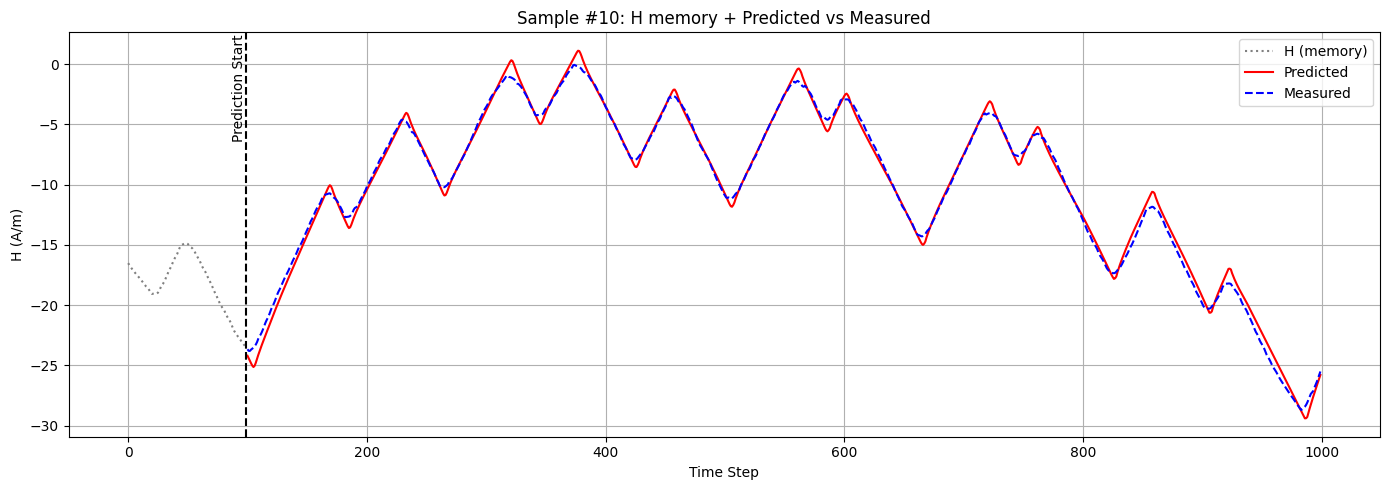

In [13]:
# Plot one example (memory + prediction)
n_plot = 10
mem_len = idx_st_list[n_plot]
pred_len = y_pred.shape[1] - mem_len

in_H_plot = y_pred[n_plot, :mem_len]           # memory input
pred_plot = y_pred[n_plot, mem_len:]           # prediction
meas_plot = y_meas[n_plot, mem_len:]           # ground truth

plt.figure(figsize=(14, 5))
plt.plot(range(mem_len), in_H_plot, label='H (memory)', linestyle=':', color='gray')
plt.plot(range(mem_len, mem_len + pred_len), pred_plot, label='Predicted', color='r')
plt.plot(range(mem_len, mem_len + pred_len), meas_plot, label='Measured', linestyle='--', color='b')

plt.axvline(x=mem_len - 1, color='k', linestyle='--')  # prediction start
plt.text(mem_len - 1, plt.ylim()[1]*0.95, 'Prediction Start', rotation=90, va='top', ha='right')

plt.xlabel("Time Step")
plt.ylabel("H (A/m)")
plt.title(f"Sample #{n_plot}: H memory + Predicted vs Measured")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


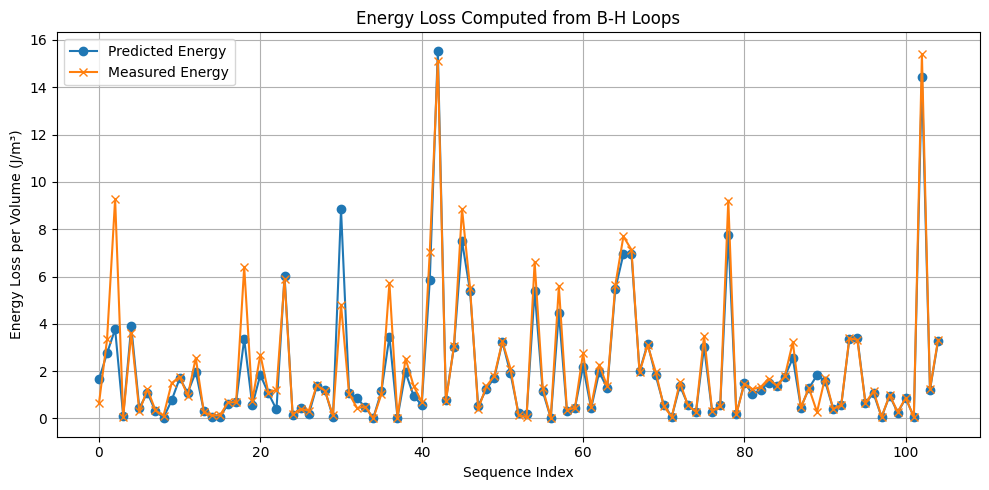

NRMSE: 39.77666323876542 %


In [14]:
# Plot predicted vs. measured energy loss and NRMSE for 105 sequences of 1,000 steps

energy_pred = compute_total_energy(B, y_pred)
energy_meas = compute_total_energy(B, y_meas)

plt.figure(figsize=(10, 5))
plt.plot(energy_pred, label='Predicted Energy', marker='o')
plt.plot(energy_meas, label='Measured Energy', marker='x')
plt.xlabel("Sequence Index")
plt.ylabel("Energy Loss per Volume (J/m³)")
plt.title("Energy Loss Computed from B-H Loops")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print('NRMSE:', np.sqrt(np.mean((energy_pred - energy_meas) ** 2)) / np.mean(np.abs(energy_meas)) * 100,'%')